# Imports

In [1]:
# Libraries
import numpy as np
import pandas as pd
from collections import Counter
from unidecode import unidecode
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinjerusalmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kevinjerusalmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kevinjerusalmi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kevinjerusalmi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Overview & integrity checks

### Overview

In [2]:
df_train = pd.read_csv("train.csv")
df_train.head(1)

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          287113 non-null  object
 1   article     287113 non-null  object
 2   highlights  287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB


In [4]:
print("Columns ", list(df_train.columns))
print("Number of articles: ", df_train.shape[0])
print("NaNs: ", df_train.isna().sum().sum())
print("Duplicated ids: ", df_train.duplicated(subset= ['id']).sum())
print("Duplicated articles: ", df_train.duplicated(subset= ['article', 'highlights']).sum())
print("Very short articles (< 50 characters): ", df_train[df_train.article.str.len() < 50].shape[0])

Columns  ['id', 'article', 'highlights']
Number of articles:  287113
NaNs:  0
Duplicated ids:  0
Duplicated articles:  3098
Very short articles (< 50 characters):  1


In [5]:
print('Example of an article and its summary: \n')

print("Article: \n")
sample = df_train.sample()
article = sample["article"].values[0]
print(article)
print("\nSummary: \n")
summary = sample["highlights"].values[0]
print(summary)

Example of an article and its summary: 

Article: 

(CNN) -- Drew Manning thought he had the body of the ideal man: 6 feet 2 inches of tanned musculature, sculpted arms and washboard abs that narrowed to a firm, 34-inch waist. His perfectly chiseled body was hairless due to regular "manscaping." People assumed he worked out three hours a day, seven days a week, but the 31-year-old personal trainer said nutrition was really the key to his dream body. As for working out, he indulged in his favorite activity for only about 45 minutes a day, four to five days a week. Then, Manning's once impressive muscles softened to pounds of bloated fat -- on purpose. Manning, a personal trainer, decided to gain nearly 70 pounds so he could better understand how his clients feel. He then planned to lose the weight to show that no matter the numbers they faced, others could get fit, too. He called it his "Fit 2 Fat 2 Fit" campaign, and documented it on a blog, and a book that debuts in June. He expected 

### Integrity checks & quick cleaning

Before we start the data analysis, let's make some changes:
* remove duplicates

In [6]:
df_train = df_train.drop_duplicates(subset= ['article', 'highlights'])

In [7]:
# No duplicated id
assert len(df_train.id.unique()) == df_train.shape[0]
# No duplicated article
assert df_train.duplicated(subset= ['article', 'highlights']).sum() == 0

# Preprocessing & Feature Engineering

In [8]:
# Slicing the dataset to save time
df = df_train.sample(10000)

### Articles

#### Characters

Let's look at the characters present in the articles and the summaries.

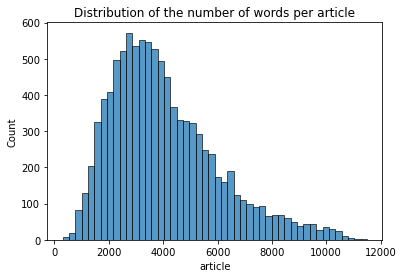

In [9]:
sns.histplot(df["article"].apply(len))
plt.title('Distribution of the number of words per article');

In [10]:
RARE_OCCURENCES_CHAR = 50
char_counter = Counter(''.join(df['article'].apply(lambda article: unidecode(article.lower())).tolist()))
low_frequency_chars = {k:v for k,v in dict(char_counter.items()).items() if v < RARE_OCCURENCES_CHAR}
low_frequency_chars

{'{': 13, '\\': 16, '}': 13, '`': 29, '<': 7, '~': 4, 'Y': 3, 'C': 5}

#### Words

In [11]:
# Article to list of cleaned words:
translator = str.maketrans(string.punctuation, " " * len(string.punctuation))
df["articles_words"] = df["article"].apply(lambda article: unidecode(article.translate(translator).lower()).split( ))

In [12]:
# Removing digits and one letter words for displaying.
def farther_cleaning(words):
    return [word for word in words if not(len(word)==1 or word.isdigit())]
    
df["articles_words"] = df["articles_words"].apply(farther_cleaning)

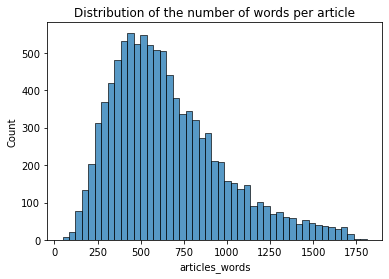

In [13]:
sns.histplot(df["articles_words"].apply(len))
plt.title('Distribution of the number of words per article')
plt.show();

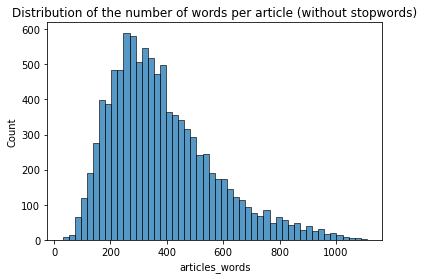

In [14]:
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

without_stop_words = df["articles_words"].apply(remove_stopwords)
sns.histplot(without_stop_words.apply(len))
plt.title('Distribution of the number of words per article (without stopwords)');

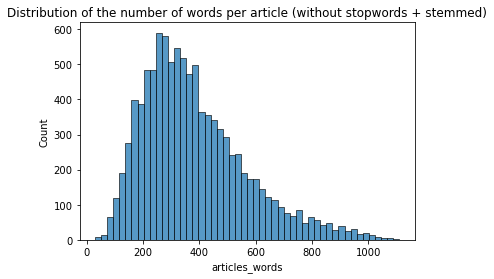

In [15]:
def stemming(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

stemmed = without_stop_words.apply(stemming)
sns.histplot(stemmed.apply(len))
plt.title('Distribution of the number of words per article (without stopwords + stemmed)');

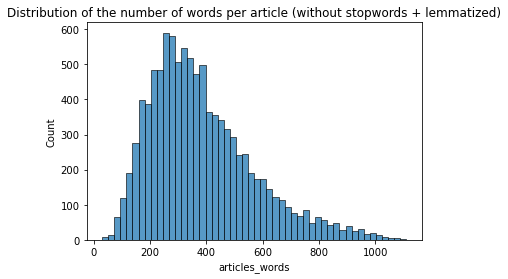

In [16]:
def lemmatizing(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

lemmatized = without_stop_words.apply(lemmatizing)
sns.histplot(lemmatized.apply(len))
plt.title('Distribution of the number of words per article (without stopwords + lemmatized)');

In [17]:
# Get a list of all words:
all_words = df['articles_words'].explode().tolist()
stop_words = set(stopwords.words('english'))

word_counter_with_stopwords = Counter(list(all_words))

word_counter_without_stopwords = word_counter_with_stopwords.copy()
for word in stop_words:
    word_counter_without_stopwords.pop(word, None)
    
word_counter_stemmed = Counter(stemmed.explode().tolist())
word_counter_lemmatized = Counter(lemmatized.explode().tolist())

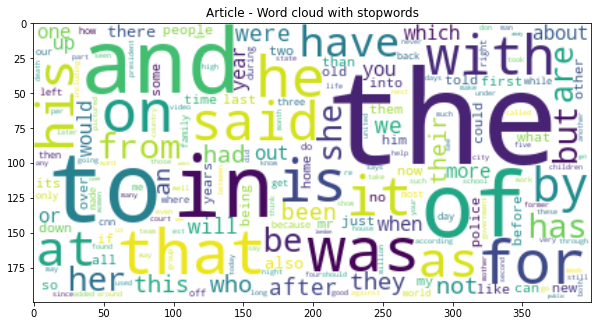

In [18]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_with_stopwords)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Article - Word cloud with stopwords')
plt.show()

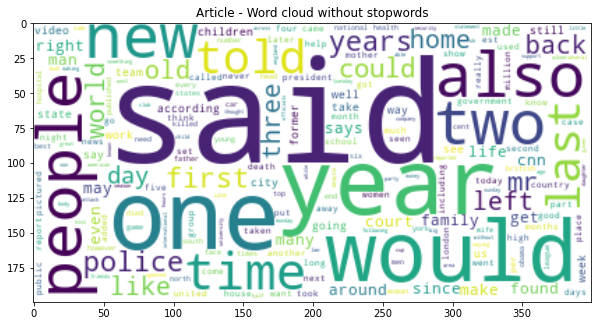

In [19]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_without_stopwords)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Article - Word cloud without stopwords')
plt.show()

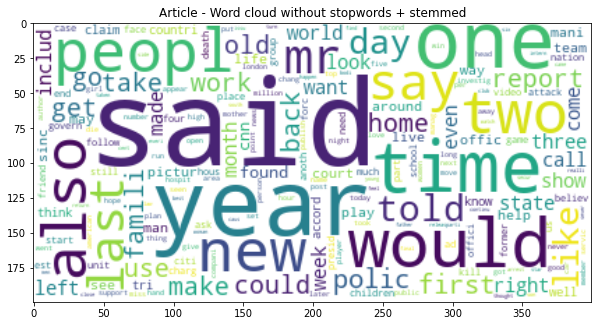

In [20]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_stemmed)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Article - Word cloud without stopwords + stemmed')
plt.show()

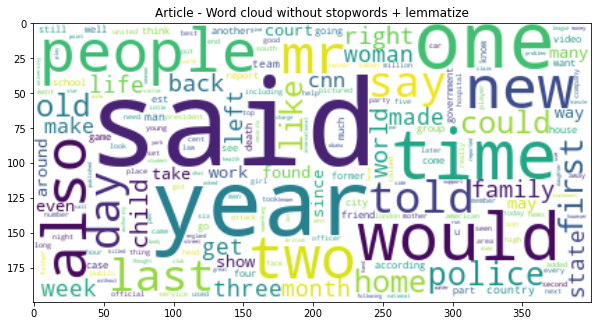

In [21]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_lemmatized)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Article - Word cloud without stopwords + lemmatize')
plt.show()

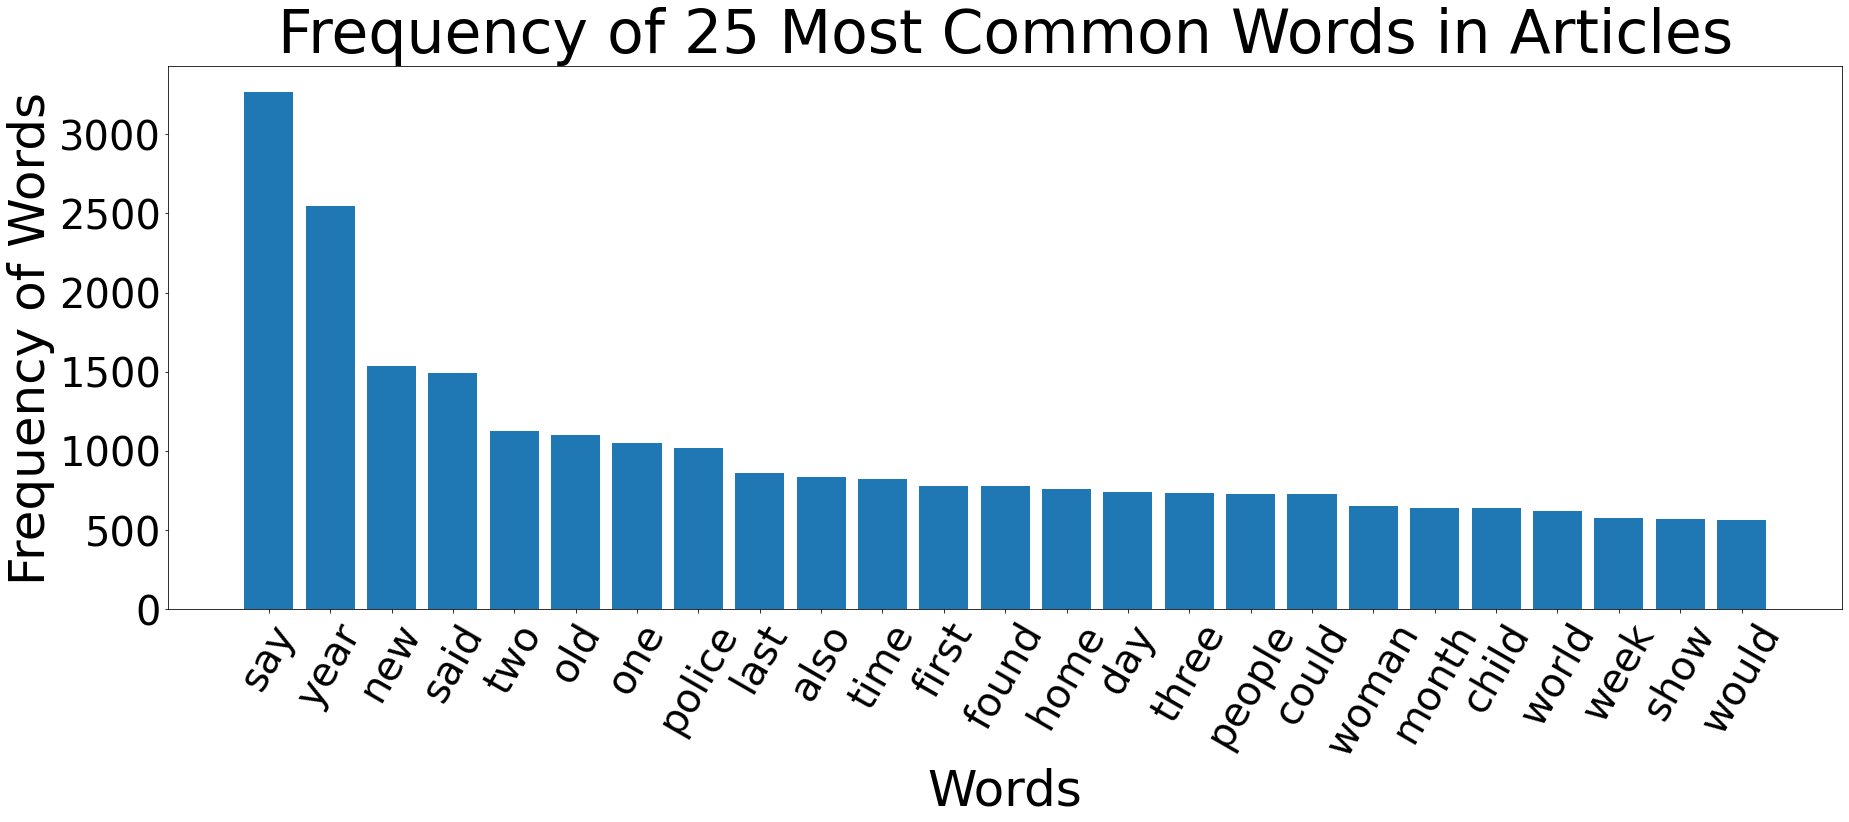

In [43]:
dic = dict(word_counter_lemmatized.most_common(25))
words = dic.keys()
freq = dic.values()
plt.figure(figsize=(30, 10))
plt.bar(words, freq)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Articles', fontsize=60)
plt.show()

#### Sentences

In [23]:
# Article to list of sentences:
df["articles_sentences"] = df["article"].apply(lambda article: sent_tokenize(article))

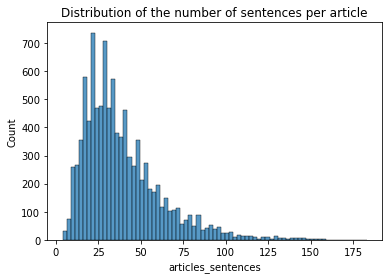

In [24]:
sns.histplot(df["articles_sentences"].apply(len))
plt.title('Distribution of the number of sentences per article');

### Summaries

#### Characters

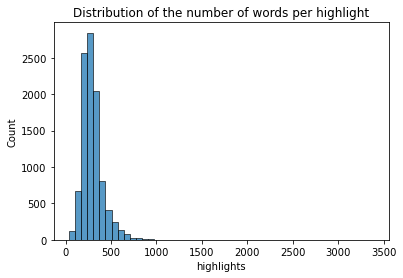

In [25]:
sns.histplot(df["highlights"].apply(len), bins= 50)
plt.title('Distribution of the number of words per highlight');

In [26]:
RARE_OCCURENCES_CHAR = 50
char_counter = Counter(''.join(df['highlights'].apply(lambda article: unidecode(article.lower())).tolist()))
low_frequency_chars = {k:v for k,v in dict(char_counter.items()).items() if v < RARE_OCCURENCES_CHAR}
low_frequency_chars

{'{': 3,
 '}': 3,
 '#': 19,
 '+': 14,
 '@': 15,
 '[': 8,
 ']': 8,
 'E': 6,
 'U': 6,
 'R': 6,
 'Y': 1,
 '=': 1,
 '_': 5,
 'C': 1}

#### Words

In [27]:
# Highlights to list of cleaned words:
df["highlights_words"] = df["highlights"].apply(lambda article: unidecode(article.translate(translator).lower()).split( ))

# Removing digits and one letter words for displaying.
df["highlights_words"] =  df["highlights_words"].apply(farther_cleaning)

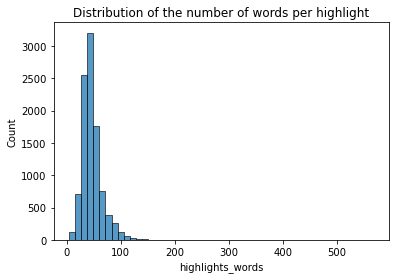

In [28]:
sns.histplot(df["highlights_words"].apply(len), bins=50)
plt.title('Distribution of the number of words per highlight')
plt.show();

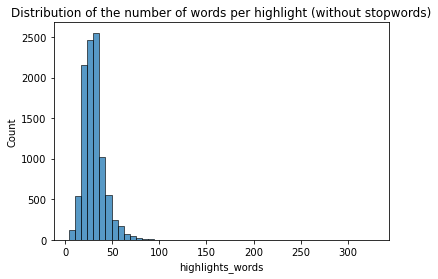

In [29]:
without_stop_words = df["highlights_words"].apply(remove_stopwords)
sns.histplot(without_stop_words.apply(len), bins=50)
plt.title('Distribution of the number of words per highlight (without stopwords)');

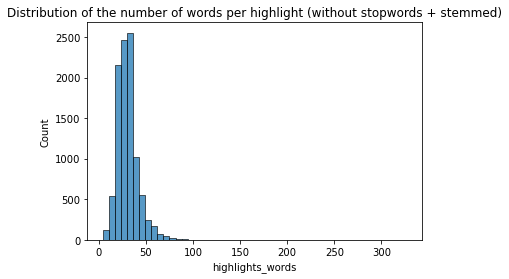

In [30]:
stemmed = without_stop_words.apply(stemming)
sns.histplot(stemmed.apply(len), bins=50)
plt.title('Distribution of the number of words per highlight (without stopwords + stemmed)');

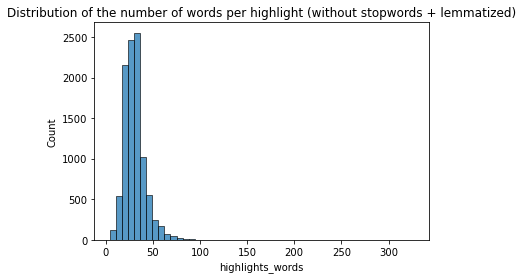

In [31]:
lemmatized = without_stop_words.apply(lemmatizing)
sns.histplot(lemmatized.apply(len), bins=50)
plt.title('Distribution of the number of words per highlight (without stopwords + lemmatized)');

In [32]:
# Get a list of all words:
all_words = df['highlights_words'].explode().tolist()
stop_words = set(stopwords.words('english'))

word_counter_with_stopwords = Counter(list(all_words))

word_counter_without_stopwords = word_counter_with_stopwords.copy()
for word in stop_words:
    word_counter_without_stopwords.pop(word, None)
    
word_counter_stemmed = Counter(stemmed.explode().tolist())
word_counter_lemmatized = Counter(lemmatized.explode().tolist())

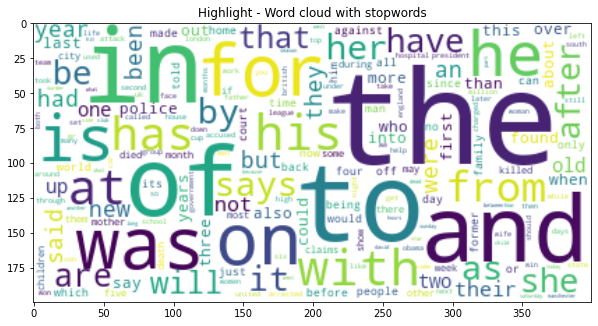

In [33]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_with_stopwords)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Highlight - Word cloud with stopwords')
plt.show()

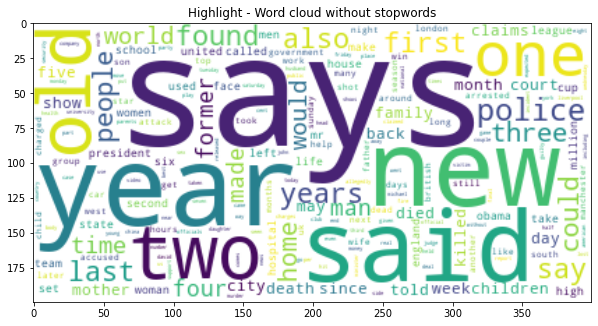

In [34]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_without_stopwords)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Highlight - Word cloud without stopwords')
plt.show()

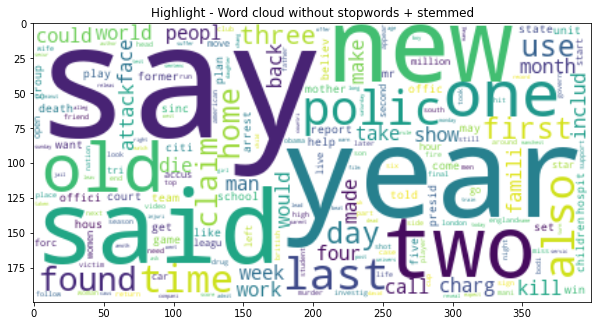

In [35]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_stemmed)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Highlight - Word cloud without stopwords + stemmed')
plt.show()

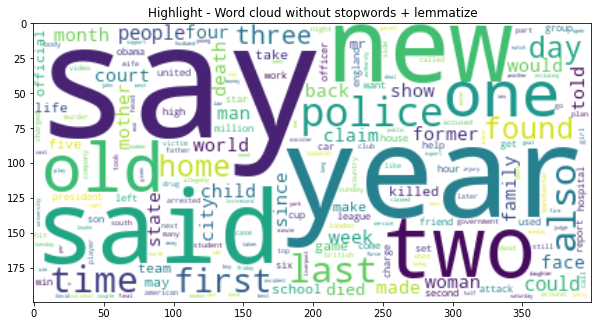

In [36]:
cloud_generator = WordCloud(background_color='white',random_state=1)
wordcloud_image = cloud_generator.fit_words(word_counter_lemmatized)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title('Highlight - Word cloud without stopwords + lemmatize')
plt.show()

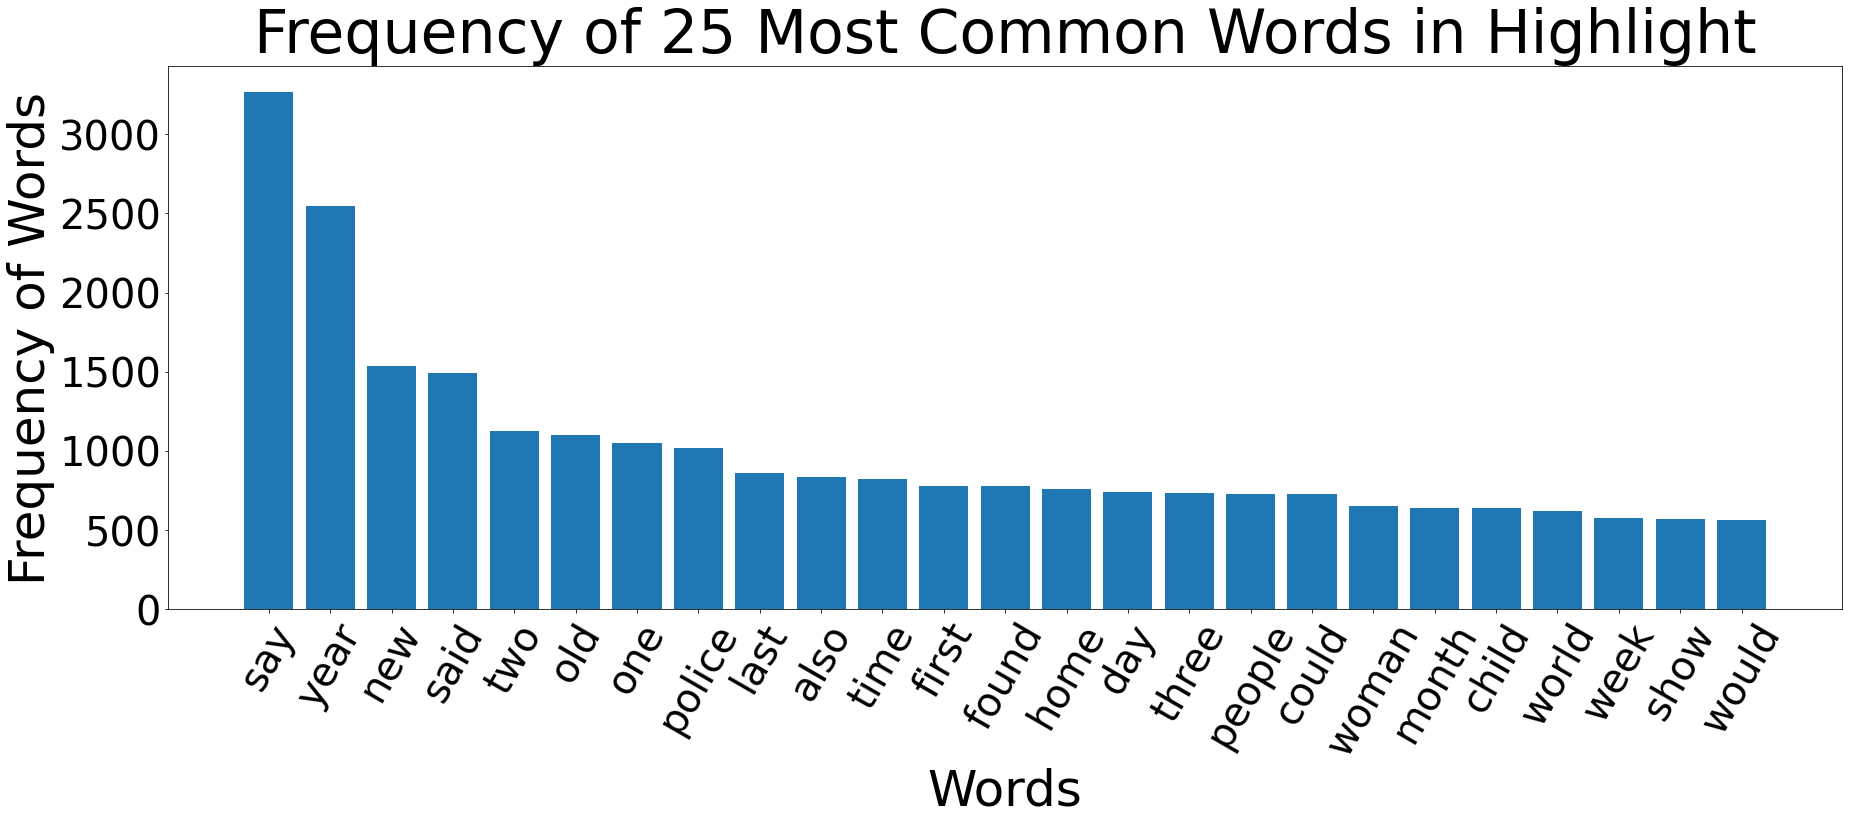

In [42]:
dic = dict(word_counter_lemmatized.most_common(25))
words = dic.keys()
freq = dic.values()
plt.figure(figsize=(30,10))
plt.bar(words, freq)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Highlight', fontsize=60)
plt.show()

#### Sentences

In [38]:
# Article to list of sentences:
df["highlights_sentences"] = df["highlights"].apply(lambda article: sent_tokenize(article))

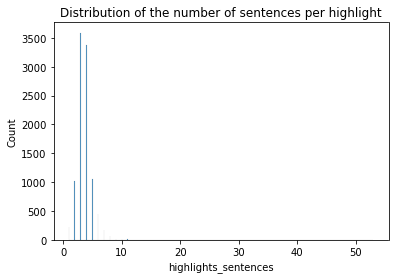

In [39]:
sns.histplot(df["highlights_sentences"].apply(len))
plt.title('Distribution of the number of sentences per highlight');

# Exploration

In [40]:
df

,id,article,highlights,articles_words,articles_sentences,highlights_words,highlights_sentences
74480,d322d07348692cfdced01ef1ada0793c70e5bf3b,By . Alex Lazcano for Daily Mail Australia . A...,14 guitars have been stolen from a property in...,"[by, alex, lazcano, for, daily, mail, australi...","[By ., Alex Lazcano for Daily Mail Australia ....","[guitars, have, been, stolen, from, property, ...",[14 guitars have been stolen from a property i...
30047,5569c84dab9169907197143f8b0263f23d29c08a,"(CNN) -- South Korean pop star Rain, who stars...","Korean singer Rain is a huge hit in Asia, but ...","[cnn, south, korean, pop, star, rain, who, sta...","[(CNN) -- South Korean pop star Rain, who star...","[korean, singer, rain, is, huge, hit, in, asia...","[Korean singer Rain is a huge hit in Asia, but..."
286939,ffcb22794fbf2635808be84e1933e023fb86c5a4,(CNN) -- A Maryland man recently died of rabie...,A Maryland man who received a tainted organ in...,"[cnn, maryland, man, recently, died, of, rabie...",[(CNN) -- A Maryland man recently died of rabi...,"[maryland, man, who, received, tainted, organ,...",[A Maryland man who received a tainted organ i...
33391,5ef989cbadefc286da72cc2cb8704e6536698a6a,"Adel Daoud, 18, is suspected of a terrorist pl...","Adel Daoud, 18, arrested on Friday following F...","[adel, daoud, is, suspected, of, terrorist, pl...","[Adel Daoud, 18, is suspected of a terrorist p...","[adel, daoud, arrested, on, friday, following,...","[Adel Daoud, 18, arrested on Friday following ..."
138891,3f9fb2fed496fed600e48bffececf5be3db8f10e,Read Charlie's Sale story on the real reasons ...,Paul Downton says the ECB didn't deal with Kev...,"[read, charlie, sale, story, on, the, real, re...",[Read Charlie's Sale story on the real reasons...,"[paul, downton, says, the, ecb, didn, deal, wi...",[Paul Downton says the ECB didn't deal with Ke...
...,...,...,...,...,...,...,...
93201,03e4d24c100f39c4124095ef1b65bc5cc2dc538d,By . Mike Dawes . Joel Campbell is on the brin...,Joel Campbell shone for Costa Rica in the Worl...,"[by, mike, dawes, joel, campbell, is, on, the,...","[By ., Mike Dawes ., Joel Campbell is on the b...","[joel, campbell, shone, for, costa, rica, in, ...",[Joel Campbell shone for Costa Rica in the Wor...
124906,2d71f12f59f283789c7dbcd7023f6155c945106b,"Olympic cycling champion Dani King, 23, has le...",King crashed during training in South Wales la...,"[olympic, cycling, champion, dani, king, has, ...","[Olympic cycling champion Dani King, 23, has l...","[king, crashed, during, training, in, south, w...",[King crashed during training in South Wales l...
101712,0f18a06bd539d1de1e3abf38469e1d14030ed41b,"Existing on a spartan diet of nuts, seeds, fru...","Susan Reynolds, 29, eats nothing but raw fruit...","[existing, on, spartan, diet, of, nuts, seeds,...","[Existing on a spartan diet of nuts, seeds, fr...","[susan, reynolds, eats, nothing, but, raw, fru...","[Susan Reynolds, 29, eats nothing but raw frui..."
8044,16c0b82edb035e5061ab884a8302b23ad1498a3f,"PUBLISHED: . 11:16 EST, 8 January 2013 . | . U...",Mohammed Khan and Shajah Rehman were racing .\...,"[published, est, january, updated, est, januar...","[PUBLISHED: ., 11:16 EST, 8 January 2013 ., | ...","[mohammed, khan, and, shajah, rehman, were, ra...",[Mohammed Khan and Shajah Rehman were racing ....
